# 作業目標:
    
    取得各種優化器的運算結果

In [1]:
from __future__ import print_function

from tensorflow.keras.datasets import cifar10
import mxnet as mx
import mxnet.gluon as gl
import numpy as np
import pandas as pd
import sys

sys.path.append('D:/MyDeepLearning/Company/Mxnet/MxnetGluon')
import gluonbook as gb
np.random.seed(10)

In [2]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

num_classes = 10

data_augmentation = True
num_predictions = 20



In [3]:
def preproc_x(x, flatten=True):
    min_x = np.min(x)
    max_x = np.max(x)
    mean_x = np.mean(x)
    x = (x-mean_x)/(max_x-min_x)
    
    if flatten:
        x = x.reshape((len(x), -1))
    return x


In [4]:

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)


x_train_normalize = x_train.astype('float32')
x_test_normalize = x_test.astype('float32')

x_train_normalize = mx.nd.array(x_train_normalize).reshape((-1,3,32,32))
x_test_normalize = mx.nd.array(x_test_normalize).reshape((-1,3,32,32))

y_label_train = mx.nd.array(y_train).reshape((-1,))
y_label_test = mx.nd.array(y_test).reshape((-1,))




x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
model = gl.nn.HybridSequential()
model.add(gl.nn.Conv2D(channels = 32, kernel_size = 3, activation = 'relu',padding = 1))
model.add(gl.nn.Dropout(rate=0.25))
model.add(gl.nn.MaxPool2D(pool_size=2))
model.add(gl.nn.Conv2D(channels = 64, kernel_size = 3, activation = 'relu', padding = 1))
model.add(gl.nn.Dropout(rate=0.25))
model.add(gl.nn.MaxPool2D(pool_size=2))
model.add(gl.nn.Flatten())
model.add(gl.nn.Dropout(rate=0.25))
model.add(gl.nn.Dense(1024,activation = 'relu'))
model.add(gl.nn.Dropout(rate=0.25))
model.add(gl.nn.Dense(10))


In [11]:
batch_size = 512

dataset = gl.data.ArrayDataset(x_train_normalize, y_label_train)
data_iter = gl.data.DataLoader(dataset, batch_size, shuffle=True)

valdataset = gl.data.ArrayDataset(x_test_normalize, y_label_test)
val_data_iter = gl.data.DataLoader(dataset, batch_size, shuffle=True)

#trainList = []
#testList = []



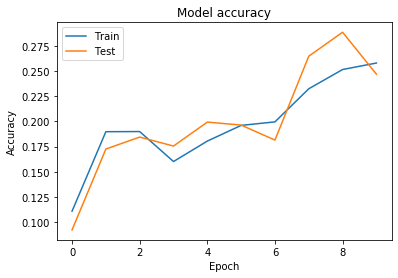

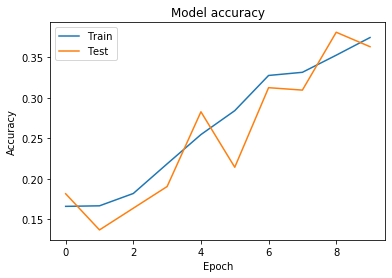

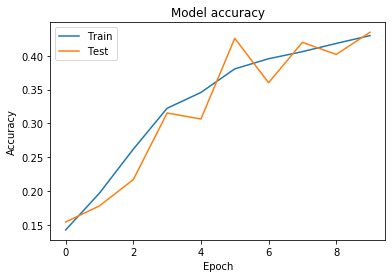

In [13]:
num_epochs = 10

for momentum in [0,0.5,0.75]:
    
    trainList = []
    testList = []
    model.initialize(mx.init.Normal(sigma=0.01),force_reinit = True, ctx = mx.gpu())  

    sgd = mx.optimizer.SGD(momentum = momentum)

    sgd.set_learning_rate(0.05)

    loss = gl.loss.SoftmaxCrossEntropyLoss()

    trainer = gl.Trainer(model.collect_params(), optimizer = sgd)


    for epoch in range(1, num_epochs + 1):
        #print(epoch)

        acc = []
        for X, y in data_iter:
    #        print(X.shape)

            X, y = X.as_in_context(mx.gpu()), y.as_in_context(mx.gpu())

            with mx.autograd.record():

                l = loss(model(X), y)

            l.backward()
            trainer.step(batch_size)

        for X,y in data_iter:

            X, y = X.as_in_context(mx.gpu()), y.as_in_context(mx.gpu())

            Trainacc = gb.ClassifierMetrics(y,model(X))

            acc.append(Trainacc)

        acc = np.mean(acc)

        trainList.append(acc)

        acc = []

        for X_val, y_val in val_data_iter:

            X, y = X_val.as_in_context(mx.gpu()), y_val.as_in_context(mx.gpu())

            Testacc = gb.ClassifierMetrics(y,model(X))

            acc.append(Trainacc)

        acc = np.mean(acc)

        testList.append(acc)
        
    import matplotlib.pyplot as plt
    %matplotlib inline

    # Plot training & validation accuracy values
    plt.plot(trainList)
    plt.plot(testList)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    